# Imports 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import parselmouth # for clalculating pitch with praat
from tqdm import tqdm
import pathlib

# Loading the tagged data (I took the prepared data. In practice we should take the data from the DB..)

## load tagged TAL

In [79]:
a=pd.read_parquet("/net/mraid11/export/dharelg/datasets/all_05012023/tal_tagged_xy_table.parquet")
# filtering untagged
a = a[~a.Prototype.str.startswith("!")]

a = a[a.columns[:19]]

full_audio_path=f"/net/mraid11/export/dharelg/datasets/this_american_life/audio_wo_music_dataset/" + a.episode_id.astype(int).astype(str) + ".mp3"
a = a.assign(full_audio_path=full_audio_path)

# making prototype id unique across episodes
a.loc[:,"Prototype_id"] = a.Prototype_id.astype(str).str.cat(a.episode_id.astype(int).astype(str),sep="_")

In [81]:
aa= a.groupby("Prototype_id")["Prototype"].first()

In [82]:
aa

Prototype_id
0_1        Q
0_140      C
0_22       C
0_5        C
0_66       C
          ..
9982_80    C
9986_22    C
9987_66    D
9992_80    C
999_99     D
Name: Prototype, Length: 6775, dtype: object

## load SBC

In [4]:
b = pd.read_csv("/net/mraid11/export/dharelg/datasets/all_05012023/sbc_words.csv")

b = b[b.columns[3:14]]
b.loc[:,"episode_id"] = b.full_audio_path.str[-10:-4]  
b.loc[:,"Prototype_id"] = b.iu_id.astype(int).astype(str) + "_" + b["episode_id"]
b.loc[:,"Prototype"] = "D" # hack. not the real values

## combine the data into a single table

In [5]:
words_w_tags = pd.concat([a,b])#a.copy() #a[a.episode_id==1]

In [6]:
## I sampled some small prototype to do sanity checks along the way
example_iu = words_w_tags[(words_w_tags.Prototype_id=="528_1")]
example_iu.shape

(3, 22)

In [7]:
example_iu

,word_id,begin,end,word,Focus,Focus_id,Prototype,Prototype_id,Comments,Comments_id,...,text,xmin,xmax,annotation_num,tier_name,speaker_id,past_split_id,full_audio_path,is_iu_start,iu_id
107,132.0,528.0,533.0,About,2.0,528.0,D,528_1,None,NaN,...,about,56.01,56.23,4.0,words,Ira Glass,Ira Glass_54.89,/net/mraid11/export/dharelg/datasets/this_amer...,NaN,NaN
108,133.0,534.0,535.0,a,NaN,NaN,D,528_1,None,NaN,...,a,56.23,56.27,5.0,words,Ira Glass,Ira Glass_54.89,/net/mraid11/export/dharelg/datasets/this_amer...,NaN,NaN
109,134.0,536.0,542.0,minute,1.0,536.0,D,528_1,None,NaN,...,minute,56.27,56.62,6.0,words,Ira Glass,Ira Glass_54.89,/net/mraid11/export/dharelg/datasets/this_amer...,NaN,NaN


# Getting the pitch

In [11]:
## the next code loops over all audio files. for each file it calculates pitch using (This part takes about 10 minutes to run!)
df_l=[]
for sound_file in tqdm(words_w_tags.full_audio_path.unique()): 
    # select relevant part of the dataframe
    words_w_tags_sel = words_w_tags[words_w_tags["full_audio_path"]==sound_file]
    episode_id = words_w_tags_sel.episode_id.iloc[0]
    # get pitch vector from praat (you might want to change this part to try different pitch retrieval algorithm)
    snd=parselmouth.Sound(sound_file)
    snd_part = snd.extract_part(
        words_w_tags_sel.xmin.min(),
        words_w_tags_sel.xmax.max()
    )
    pitch = snd_part.to_pitch()
    pitch_frequency = pitch.selected_array['frequency']
    time=np.arange(0,pitch_frequency.shape[0])*pitch.dt
    df=pd.DataFrame(dict(
        time=time,
        pitch_frequency=pitch_frequency,
    ))
    # adding word_id and Prototype_id amd speaker_id to the pitch vector
    df = df.set_index("time")
    df = df.assign(word_id=np.nan,Prototype_id=np.nan,speaker_id=np.nan)
    sss = words_w_tags_sel.xmin.min()
    for _, s in words_w_tags_sel[["xmin","xmax","word_id"]].iterrows(): 
        df.loc[s.xmin - sss:s.xmax - sss,"word_id"] = s.word_id
    prototypes = words_w_tags_sel.groupby("Prototype_id").agg(
        {"xmin":"min","xmax":"max","speaker_id":"first"}
    ).reset_index()
    for _, s in prototypes.iterrows(): 
        df.loc[s.xmin - sss:s.xmax - sss,"Prototype_id"] = s.Prototype_id
        df.loc[s.xmin - sss:s.xmax - sss,"speaker_id"] = s.speaker_id
    df = df.reset_index()
    # caching the dataframe
    pathlib.Path("pitch_values_cache").mkdir(exist_ok=True)
    df_path = f"pitch_values_cache/{episode_id}.parquet"
    df.to_parquet(df_path)
    df_l.append(df_path)
# loading all dataframes
df_all = pd.concat([pd.read_parquet(p) for p in df_l])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [10:30<00:00,  9.27s/it]


In [14]:
df_all.shape

(11325587, 5)

In [15]:
df_all.head()

,time,pitch_frequency,word_id,Prototype_id,speaker_id
0,0.00,0.000000,0.0,0_1,Ira Glass
1,0.01,0.000000,0.0,0_1,Ira Glass
2,0.02,0.000000,0.0,0_1,Ira Glass
3,0.03,162.966202,0.0,0_1,Ira Glass
4,0.04,160.205475,0.0,0_1,Ira Glass


# CAN START FROM HERE BECAUSE THE ABOVE PART IS CACHED

# imports (again)

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import parselmouth # for clalculating pitch with praat
from tqdm import tqdm
import pathlib

In [10]:
df_all = pd.concat([pd.read_parquet(p) for p in pathlib.Path("pitch_values_cache").glob("*.parquet")])

In [11]:
df_all.head()

,time,pitch_frequency,word_id,Prototype_id,speaker_id
0,0.00,0.000000,0.0,0_1,Ira Glass
1,0.01,0.000000,0.0,0_1,Ira Glass
2,0.02,0.000000,0.0,0_1,Ira Glass
3,0.03,162.966202,0.0,0_1,Ira Glass
4,0.04,160.205475,0.0,0_1,Ira Glass


In [18]:
df_all.Prototype_id.nunique()

37382

In [20]:
pitch_w_tags = df_all.copy()
# changing the feature name to "values" (no real reason for that. just convinience)
pitch_w_tags=pitch_w_tags.rename(columns={"pitch_frequency":"values"})  
# removing areas that don't belong to any prototype
pitch_w_tags=pitch_w_tags.loc[pitch_w_tags["Prototype_id"].notna(),:]
# remove 0 values (can change depending on the feautre!!!!)
pitch_w_tags = pitch_w_tags[pitch_w_tags["values"]>0]

# plot of feature in normalized time for all IUs 

## calculating the normalized time bins for each 
- norm_time: the time is projected to be from 0 to 1
- norm_time_binned: each norm time is mapped to its bin 
- norm_time_binned_float: each bin range is mapped to a float

In [47]:
bin_res = 0.05

# creating normalized binned time - time is from 0 to 1 and in bins the size of {bin_res}
pitch_w_tags.loc[:,"start_time"] = pitch_w_tags.groupby("Prototype_id")["time"].transform("min")
pitch_w_tags.loc[:,"end_time"] = pitch_w_tags.groupby("Prototype_id")["time"].transform("max")
pitch_w_tags.loc[:,"norm_time"] = ((pitch_w_tags["time"] - pitch_w_tags["start_time"]) / (pitch_w_tags["end_time"] - pitch_w_tags["start_time"]))
pitch_w_tags.loc[:,"norm_time_binned"] = pd.cut(pitch_w_tags["norm_time"],np.linspace(0,1,int(1/bin_res+1)),include_lowest=True) 
index_categories = pitch_w_tags.norm_time_binned.cat.categories
category_mapping = {k:k.left for k in index_categories.values}
pitch_w_tags.loc[:,"norm_time_binned_float"] = pitch_w_tags["norm_time_binned"].map(category_mapping)

In [49]:
pitch_w_tags.head()

,time,values,word_id,Prototype_id,speaker_id,start_time,end_time,norm_time,norm_time_binned,norm_time_binned_float
3,0.03,162.966202,0.0,0_1,Ira Glass,0.03,0.34,0.000000,"(-0.001, 0.05]",-0.001
4,0.04,160.205475,0.0,0_1,Ira Glass,0.03,0.34,0.032258,"(-0.001, 0.05]",-0.001
5,0.05,156.059560,0.0,0_1,Ira Glass,0.03,0.34,0.064516,"(0.05, 0.1]",0.050
6,0.06,152.045778,0.0,0_1,Ira Glass,0.03,0.34,0.096774,"(0.05, 0.1]",0.050
7,0.07,149.972863,0.0,0_1,Ira Glass,0.03,0.34,0.129032,"(0.1, 0.15]",0.100


## removing 0 pitch, calculating semitones, doing speaker normalization and bin aggregation
- values: pitch 
- speaker_median: the median pitch frequency of the speaker
- values_semitone: pitch in semitones (0 is speakers median)
- values_semitone_bin_median: the median pitch in the bin (in semitones) 
- values_semitone_bin_mean: the mean pitch in the bin (in semitones)

In [51]:
# scaling and normalizing the values (scaling method can change depending on the feautre!!!!)
pitch_w_tags.loc[:,"speaker_median"] = pitch_w_tags.groupby("speaker_id")["values"].transform("median")
pitch_w_tags.loc[:,"values_semitone"] = 12*np.log(pitch_w_tags["values"]/pitch_w_tags["speaker_median"])/np.log(2)
# treating bins with more than one data point 
pitch_w_tags.loc[:,"values_semitone_bin_median"] = pitch_w_tags.groupby(["Prototype_id","norm_time_binned"])["values_semitone"].transform("median")
pitch_w_tags.loc[:,"values_semitone_bin_mean"] = pitch_w_tags.groupby(["Prototype_id","norm_time_binned"])["values_semitone"].transform("mean")
# making sure only one row per Prototype_id and bin
pitch_w_tags_wo_dups = pitch_w_tags.drop_duplicates(["Prototype_id","norm_time_binned"])

## example plot single IU

<Axes: xlabel='norm_time_binned_float'>

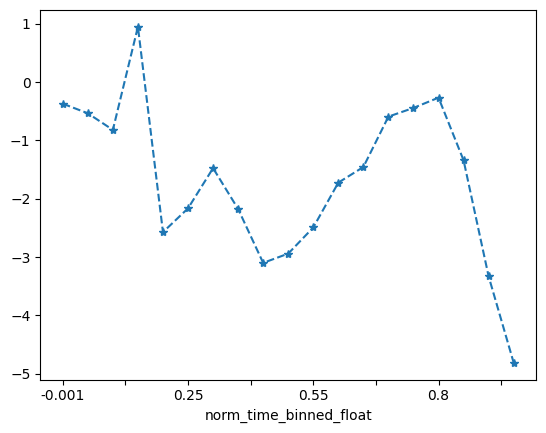

In [54]:
pitch_w_tags_wo_dups.loc[pitch_w_tags_wo_dups.Prototype_id=="528_1"].set_index("norm_time_binned_float")["values_semitone_bin_median"].plot(style="--*")

## comparing mean and median bin calculation for a single IU

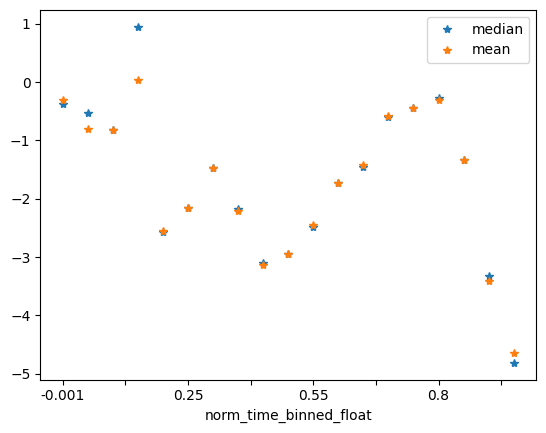

In [17]:
df = pitch_w_tags_wo_dups.loc[pitch_w_tags_wo_dups.Prototype_id=="528_1"].set_index("norm_time_binned_float")
df["values_semitone_bin_median"].plot(style="*",label="median")
df["values_semitone_bin_mean"].plot(style="*",label="mean")
plt.legend()

In [62]:
plot_data["mean"].index

CategoricalIndex([-0.001,   0.05,    0.1,   0.15,    0.2,   0.25,    0.3,
                    0.35,    0.4,   0.45,    0.5,   0.55,    0.6,   0.65,
                     0.7,   0.75,    0.8,   0.85,    0.9,   0.95],
                 categories=[-0.001, 0.050, 0.100, 0.150, ..., 0.80, 0.85, 0.90, 0.95], ordered=True, dtype='category', name='norm_time_binned_float')

In [65]:
plot_data.index.values

[-0.001, 0.050, 0.100, 0.150, 0.200, ..., 0.75, 0.80, 0.85, 0.90, 0.95]
Length: 20
Categories (20, float64): [-0.001 < 0.050 < 0.100 < 0.150 ... 0.80 < 0.85 < 0.90 < 0.95]

## ploting multiple IUs 

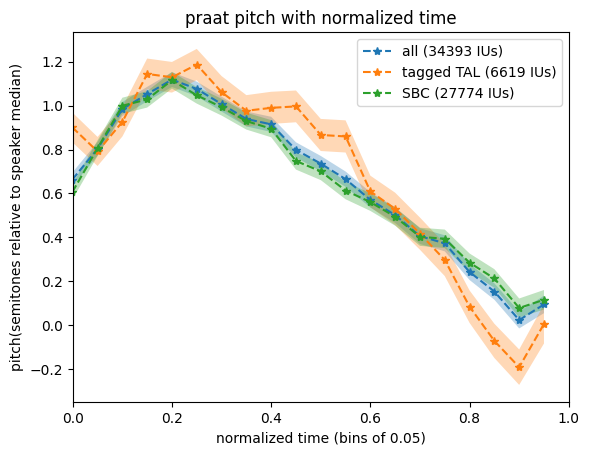

In [77]:
def plot_df(plot_data):
    label=plot_data["label"].iloc[0]
    plt.plot(plot_data["mean"],"--*",label=label,)
    plt.fill_between(
        plot_data["mean"].index,
        plot_data["mean"]-plot_data["std"]/plot_data["count"]**0.5,
        plot_data["mean"]+plot_data["std"]/plot_data["count"]**0.5,
        alpha=0.3
    )
plot_data = pitch_w_tags_wo_dups.groupby("norm_time_binned_float")["values_semitone_bin_median"].describe()
plot_df(plot_data.assign(label="all (34393 IUs)"))
plt.grid()
plt.ylabel("pitch(semitones relative to speaker median)")
plt.xlabel(f"normalized time (bins of {bin_res})")
plt.xlim(0,1)
plt.title("praat pitch with normalized time")


plot_data_wo_iraglass = pitch_w_tags_wo_dups[
    ~pitch_w_tags_wo_dups["Prototype_id"].str.contains("SBC")
].groupby("norm_time_binned_float")["values_semitone_bin_median"].describe()
plot_df(plot_data_wo_iraglass.assign(label="tagged TAL (6619 IUs)"))
plot_data_iraglass = pitch_w_tags_wo_dups[
    pitch_w_tags_wo_dups["Prototype_id"].str.contains("SBC")
].groupby("norm_time_binned_float")["values_semitone_bin_median"].describe()
plot_df(plot_data_iraglass.assign(label="SBC (27774 IUs)"))
plt.legend()
plt.grid()

In [78]:
pitch_w_tags_wo_dups.head()

,time,values,word_id,Prototype_id,speaker_id,start_time,end_time,norm_time,norm_time_binned,norm_time_binned_float,speaker_median,values_semitone,values_semitone_bin_median,values_semitone_bin_mean
3,0.03,162.966202,0.0,0_1,Ira Glass,0.03,0.34,0.000000,"(-0.001, 0.05]",-0.001,129.494874,3.980134,3.832238,3.832238
5,0.05,156.059560,0.0,0_1,Ira Glass,0.03,0.34,0.064516,"(0.05, 0.1]",0.050,129.494874,3.230421,3.004875,3.004875
7,0.07,149.972863,0.0,0_1,Ira Glass,0.03,0.34,0.129032,"(0.1, 0.15]",0.100,129.494874,2.541678,2.541678,2.541678
8,0.08,149.347644,0.0,0_1,Ira Glass,0.03,0.34,0.161290,"(0.15, 0.2]",0.150,129.494874,2.469354,2.482257,2.482257
10,0.10,151.333260,0.0,0_1,Ira Glass,0.03,0.34,0.225806,"(0.2, 0.25]",0.200,129.494874,2.698009,2.698009,2.698009


/tmp/ipykernel_6606/1084656607.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a.loc[:,"Prototype"] = a["Prototype_id"].map(aa)


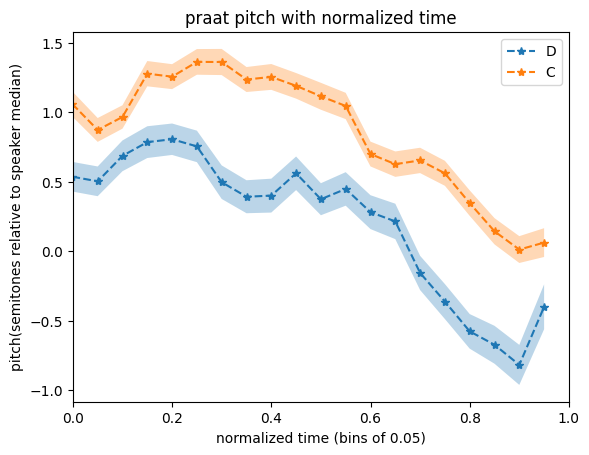

In [86]:
def plot_df(plot_data):
    label=plot_data["label"].iloc[0]
    plt.plot(plot_data["mean"],"--*",label=label,)
    plt.fill_between(
        plot_data["mean"].index,
        plot_data["mean"]-plot_data["std"]/plot_data["count"]**0.5,
        plot_data["mean"]+plot_data["std"]/plot_data["count"]**0.5,
        alpha=0.3
    )
plt.grid()
plt.ylabel("pitch(semitones relative to speaker median)")
plt.xlabel(f"normalized time (bins of {bin_res})")
plt.xlim(0,1)
plt.title("praat pitch with normalized time")


a = pitch_w_tags_wo_dups[
    ~pitch_w_tags_wo_dups["Prototype_id"].str.contains("SBC")
]
a.loc[:,"Prototype"] = a["Prototype_id"].map(aa)
d = a[a["Prototype"]=="D"].groupby("norm_time_binned_float")["values_semitone_bin_median"].describe()
plot_df(d.assign(label="D"))
c = a[a["Prototype"]=="C"].groupby("norm_time_binned_float")["values_semitone_bin_median"].describe()
plot_df(c.assign(label="C"))
plt.legend()
plt.grid()